## Введение

Цель проекта - разработка системы анализа риска ДТП. Для её выполнения были даны следующие SQL таблицы:

* collisions (информация о происшествиях):
    * `CASE_ID` - идентификационный  Номер в базе данных;
    * `COLLISION_DATE` - дата происшествия;
    * `COLLISION_TIME` - Время происшествия;
    * `INTERSECTION` - является ли место происшествие перекрёстком;
    * `WEATHER_1` - погода;
    * `COLLISION_DAMAGE` - серьёзность происшествия;
    * `PRIMARY_COLL_FACTOR` - основной фактор аварии;
    * `ROAD_SURFACE` - состояние дороги;
    * `LIGHTING` - освещение;
    * `COUNTY_CITY_LOCATION` - номер географических районов, где произошло ДТП;
    * `COUNTY_LOCATION` - названия географических районов, где произошло ДТП;
    * `DIRECTION` - направление движения;
    * `DISTANCE` - расстояние от главной дороги (метры);
    * `LOCATION_TYPE` - тип дороги;
    * `PARTY_COUNT` - количество участников;
    * `PCF_VIOLATION_CATEGORY` - категория нарушения;
    * `TYPE_OF_COLLISION` - тип аварии;
    * `MOTOR_VEHICLE_INVOLVED_WITH` - дополнительные участники ДТП;
    * `ROAD_CONDITION_1` - дорожное состояние;
    * `CONTROL_CONDITION_1` - устройство управления.

* Parties (описание участников происшествия):
    * `CASE_ID` - идентификационный  номер в базе данных;
    * `PARTY_NUMBER` - номер участника происшествия;
    * `PARTY_TYPE` - тип участника происшествия;
    * `Тип участника происшествия` - виновность участника;
    * `INSURANCE_PREMIUM` - сумма страховки (тыс. $);
    * `PARTY_DRUG_PHYSICAL` - состояние участника: физическое или с учётом принятых лекарств;
    * `PARTY_SOBRIETY` - трезвость участника;
    * `CELLPHONE_IN_USE` - наличие телефона в автомобиле (возможности разговаривать по громкой связи).
    
* Vehicles (Описание автомобиля):
    * `ID` - индекс текущей таблицы;
    * `CASE_ID` - идентификационный номер в базе данных;
    * `VEHICLE_TYPE` - тип кузова;
    * `VEHICLE_TRANSMISSION` - тип КПП;
    * `VEHICLE_AGE` - возраст автомобиля (в годах).
    
    
План работы:
1. Загрузка библиотек и подключение к базе данных;
1. Первичное исследование таблиц;
1. Статистический анализ факторов ДТП;
    * Подготовка задач для коллег и примеры их выполнения;
1. Создание модели для оценки водительского риска:
    1. Создание объеденённого датафрейма;
    1. Предоработка и предварительный анализ данных;
    1. Подготовка выборок для обучения;
    1. Обучение моделей;
    1. Сравнение моделей и выводы.
1. Анализ важности факторов ДТП:
    1. Графический анализ матрицы ошибок;
    1. Анализ важности факторов ДТП;
    1. Исследование наиболее важного фактора.
1. Общий вывод.

## Подключитесь к базе. Загрузите таблицы sql

In [1]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import Normalizer, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.metrics import ConfusionMatrixDisplay

%matplotlib inline
sns.set()
import warnings
warnings.filterwarnings('ignore')

In [2]:
db_config = {
'user': '********', # имя пользователя,
'pwd': '********', # пароль,
'host': '********,
'port': ****, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
} 

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
) 

engine = create_engine(connection_string) 

## Проведите первичное исследование таблиц

### case_ids

In [3]:
query = '''
SELECT *
FROM case_ids
LIMIT 5
'''

df = pd.read_sql_query(query, con = engine) 
df

,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021


### vehicles

In [4]:
query = '''
SELECT *
FROM vehicles
LIMIT 5
'''

df = pd.read_sql_query(query, con = engine) 
df

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5


### collisions

In [5]:
query = '''
SELECT *
FROM collisions
LIMIT 5
'''

df = pd.read_sql_query(query, con = engine) 
df

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


### parties

In [6]:
query = '''
SELECT *
FROM parties
LIMIT 5
'''

df = pd.read_sql_query(query, con = engine) 
df

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0


### Вывод

Количество таблиц и их содержание соответствует условию задачи. Общий ключ `case_id` присутствует во всех таблицах.

##  Проведите статистический анализ факторов ДТП

### Выясните, в какие месяцы происходит наибольшее количество аварий

In [7]:
query = '''
SELECT 
  DISTINCT TO_CHAR(collision_date, 'Month') AS month, DATE_TRUNC('month', collision_date) AS date, 
  COUNT(case_id) OVER(
    PARTITION BY DATE_TRUNC('month', collision_date) 
    ORDER BY 
      DATE_TRUNC('month', collision_date)
  ) 
FROM 
  collisions 
ORDER BY 
  date

'''

df = pd.read_sql_query(query, con = engine) 
df

,month,date,count
0,January,2009-01-01 00:00:00+03:00,35062
1,February,2009-02-01 00:00:00+03:00,34480
2,March,2009-03-01 00:00:00+03:00,36648
3,April,2009-04-01 00:00:00+04:00,35239
4,May,2009-05-01 00:00:00+04:00,36916
5,June,2009-06-01 00:00:00+04:00,34202
6,July,2009-07-01 00:00:00+04:00,35161
7,August,2009-08-01 00:00:00+04:00,34508
8,September,2009-09-01 00:00:00+04:00,35555
9,October,2009-10-01 00:00:00+04:00,37835


In [8]:
query = '''
SELECT 
  DISTINCT TO_CHAR(collision_date, 'Month') AS month, 
  COUNT(case_id) OVER(
    PARTITION BY TO_CHAR(collision_date, 'Month') 
    ORDER BY 
      TO_CHAR(collision_date, 'Month')
  ) 
FROM 
  collisions 
WHERE 
  EXTRACT (
    'year' 
    FROM 
      collision_date
  ) < '2012' 
ORDER BY 
  month
'''

df = pd.read_sql_query(query, con = engine) 
df

,month,count
0,April,101032
1,August,103467
2,December,107745
3,February,98373
4,January,99880
5,July,101835
6,June,99531
7,March,107036
8,May,105148
9,November,104517


Удалены неполные данные за 2012, 2013 и 2020 года

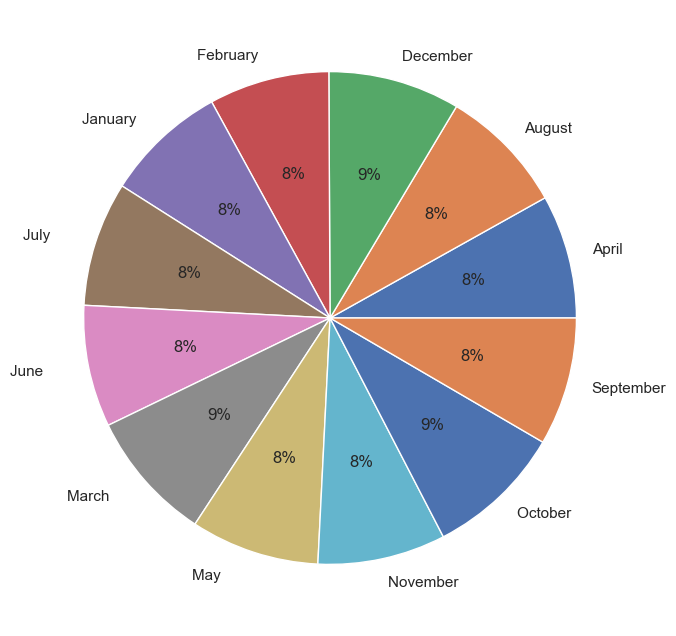

In [9]:
plt.figure(figsize=(8,8))
plt.pie(data=df, x='count', labels='month', autopct='%.0f%%');

Количество аварий относительно равномерно распределено по месяцам. Их пик наблюдается в марте.

### Скоро состоится первое совещание вашей рабочей группы. Чтобы обсуждение было конструктивным, каждый сотрудник должен понимать данные. Для этого вы должны создать подходящие аналитические задачи и поручить их решение коллегам

* Провести анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП (связать collisions и parties);
* Определить наиболее частые часы ДТП с участием более двух авто на перекрестке (таблицы collisions и parties);
* Найдти самые частые причины ДТП (таблица parties);
* Провести анализ серьёзности повреждений транспортного средства, исходя из освещения в момент ДТП (связать collisions и parties);
* Найти процент ДТП с возрастом авто более 10 лет(таблицы collisions и vehicles);
* Определить направление с наибольшим количеством ДТП(таблица collisions).


#### Провести анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП

In [10]:
query = '''
SELECT 
  collision_damage, 
  road_surface 
FROM 
  collisions 
  INNER JOIN parties ON collisions.case_id = parties.case_id 
WHERE 
  party_type = 'car' 
ORDER BY 
  road_surface

'''

df = pd.read_sql_query(query, con = engine) 
df.head()

,collision_damage,road_surface
0,small damage,dry
1,middle damage,dry
2,middle damage,dry
3,scratch,dry
4,scratch,dry


In [11]:
order = ['scratch', 'small damage', 'middle damage', 'severe damage', 'fatal']

##### dry

Text(0.5, 1.0, 'dry')

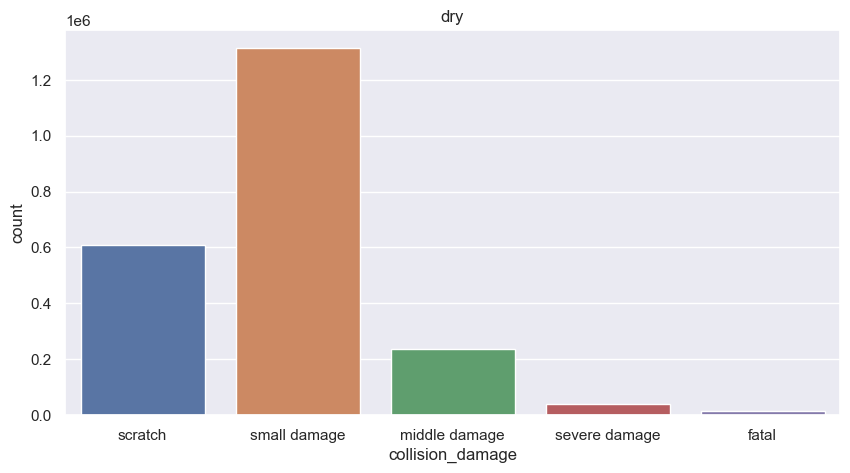

In [12]:
plt.figure(figsize=(10,5))
sns.countplot(data=df[df['road_surface'] == 'dry'], x='collision_damage', order=order)
plt.title('dry')

##### slippery

Text(0.5, 1.0, 'slippery')

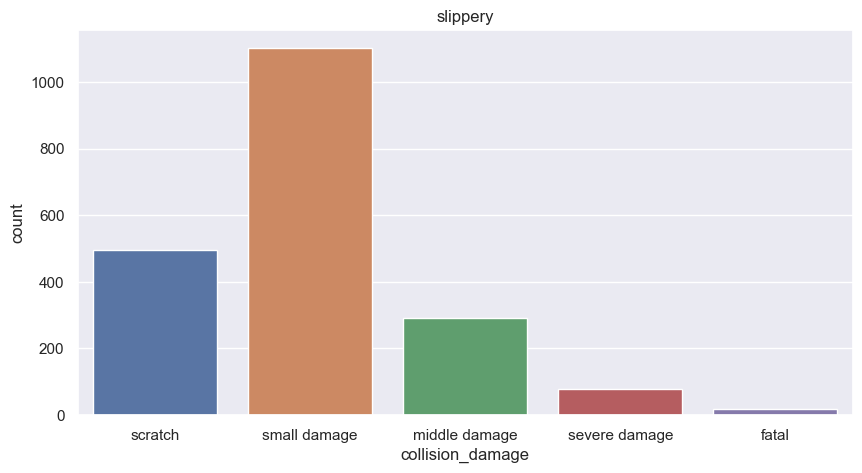

In [13]:
plt.figure(figsize=(10,5))
sns.countplot(data=df[df['road_surface'] == 'slippery'], x='collision_damage', order=order)
plt.title('slippery')

##### snowy

Text(0.5, 1.0, 'snowy')

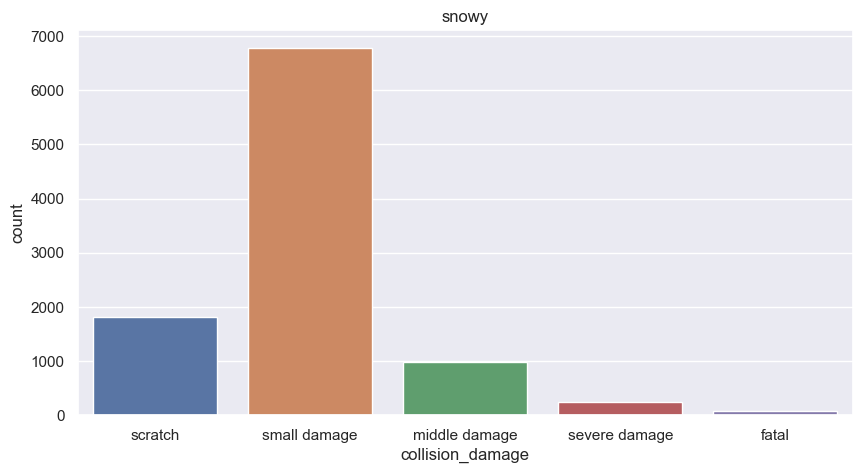

In [14]:
plt.figure(figsize=(10,5))
sns.countplot(data=df[df['road_surface'] == 'snowy'], x='collision_damage', order=order)
plt.title('snowy')

##### wet

Text(0.5, 1.0, 'wet')

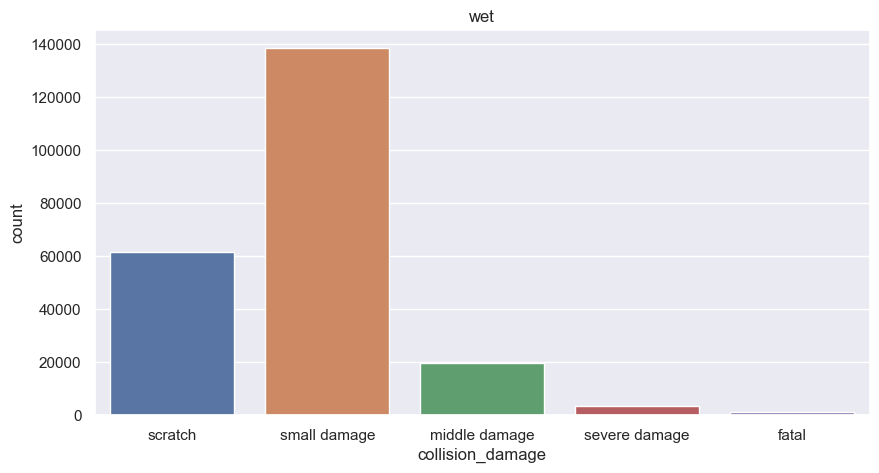

In [15]:
plt.figure(figsize=(10,5))
sns.countplot(data=df[df['road_surface'] == 'wet'], x='collision_damage', order=order)
plt.title('wet')

Пропорции количества повреждений сохроняются вне зависимости от типа дороги, за исключением скользкой, где процент серьезных повреждений выше остальных.

#### Определить наиболее частые часы ДТП с участием более двух авто на перекрестке 

In [16]:
query = '''
SELECT DISTINCT EXTRACT(HOUR FROM collision_time) AS hour,
COUNT(collisions.case_id) OVER (PARTITION BY EXTRACT(HOUR FROM collision_time) ORDER BY EXTRACT(HOUR FROM collision_time))
FROM collisions
INNER JOIN parties
ON collisions.case_id = parties.case_id
WHERE intersection = 1
AND party_count > 2
AND party_type = 'car'
ORDER BY count DESC
'''

df = pd.read_sql_query(query, con = engine) 
df.head()

,hour,count
0,17.0,6341
1,15.0,6285
2,16.0,5926
3,14.0,5677
4,18.0,5193


Text(0.5, 1.0, 'зависимость частоты ДТП от времени')

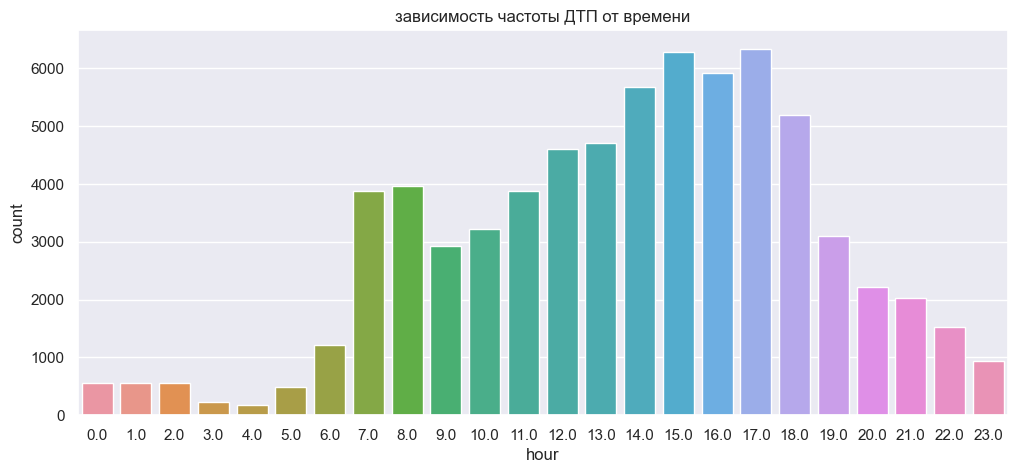

In [17]:
plt.figure(figsize=(12,5))
sns.barplot(data=df, x='hour', y='count')
plt.title('зависимость частоты ДТП от времени')

Наблюдается скачок в количествах ДТП на перекрёстках в 7:00 и 8:00, с последующим пиком в период между 15:00 и 17:00. Предположительно, это вызвано большим количеством авто на дорогах в часы пик.

## Создайте модель для оценки водительского риска

### Создание датафрейма

In [18]:
query = '''
SELECT 
  * 
FROM 
  vehicles 
  INNER JOIN parties ON vehicles.case_id = parties.case_id 
  AND vehicles.party_number = parties.party_number 
  INNER JOIN collisions ON parties.case_id = collisions.case_id 
WHERE 
  EXTRACT(
    YEAR 
    FROM 
      collision_date
  ) = 2012 
  AND party_type = 'car' 
  AND collision_damage != 'scratch'
'''

df = pd.read_sql_query(query, con = engine) 
df.head()

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age,id,case_id,party_number,party_type,...,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,1328327,5456705,1,sedan,manual,5.0,2409910,5456705,1,car,...,unknown,unknown,sideswipe,other motor vehicle,dry,normal,dark with no street lights,none,2012-01-18,20:10:00
1,1328686,5457021,2,sedan,auto,1.0,2410555,5457021,2,car,...,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,not functioning,2012-01-11,14:28:00
2,1329594,5457954,2,sedan,manual,8.0,2412316,5457954,2,car,...,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,dark with street lights,none,2012-01-05,18:33:00
3,1330992,5459631,2,coupe,auto,10.0,2415244,5459631,2,car,...,vehicle code violation,speeding,rear end,other motor vehicle,wet,normal,daylight,none,2012-02-07,15:00:00
4,1331046,5459675,1,coupe,manual,4.0,2415327,5459675,1,car,...,vehicle code violation,traffic signals and signs,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2012-01-29,21:17:00


In [19]:
columns = [
    'distance', # 
    'intersection', 
    'weather_1',
    'location_type',
    'collision_damage',
    'party_count',
    'primary_collision_factor',
    'pcf_violation_category',
    'type_of_collision',
    'motor_vehicle_involved_with',
    'road_surface',
    'road_condition_1',
    'lighting', 
    'control_device',
    'collision_time',
    'at_fault', 
    'party_sobriety', 
    'party_drug_physical',
    'cellphone_in_use',
    'vehicle_transmission',
    'vehicle_age'
]

In [20]:
df = df[columns]
df.head()

,distance,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,...,road_condition_1,lighting,control_device,collision_time,at_fault,party_sobriety,party_drug_physical,cellphone_in_use,vehicle_transmission,vehicle_age
0,500.0,0.0,clear,ramp,small damage,2,unknown,unknown,sideswipe,other motor vehicle,...,normal,dark with no street lights,none,20:10:00,0,had not been drinking,None,0.0,manual,5.0
1,387.0,0.0,clear,None,small damage,2,vehicle code violation,speeding,rear end,other motor vehicle,...,normal,daylight,not functioning,14:28:00,0,had not been drinking,None,0.0,auto,1.0
2,7.8,0.0,clear,ramp,small damage,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,...,normal,dark with street lights,none,18:33:00,0,had not been drinking,None,NaN,manual,8.0
3,2112.0,0.0,cloudy,None,middle damage,2,vehicle code violation,speeding,rear end,other motor vehicle,...,normal,daylight,none,15:00:00,0,had not been drinking,None,0.0,auto,10.0
4,0.0,1.0,clear,None,middle damage,2,vehicle code violation,traffic signals and signs,broadside,other motor vehicle,...,normal,dark with street lights,functioning,21:17:00,1,had not been drinking,None,NaN,manual,4.0


### Предобработка и исследовательский анализ данных

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   distance                     56248 non-null  float64
 1   intersection                 56073 non-null  float64
 2   weather_1                    56080 non-null  object 
 3   location_type                25932 non-null  object 
 4   collision_damage             56248 non-null  object 
 5   party_count                  56248 non-null  int64  
 6   primary_collision_factor     56137 non-null  object 
 7   pcf_violation_category       55482 non-null  object 
 8   type_of_collision            55940 non-null  object 
 9   motor_vehicle_involved_with  56086 non-null  object 
 10  road_surface                 55900 non-null  object 
 11  road_condition_1             55999 non-null  object 
 12  lighting                     56094 non-null  object 
 13  control_device  

#### дубликаты

In [22]:
df.duplicated().sum()

215

In [23]:
df = df.drop_duplicates()
df.duplicated().sum()

0

Явные дубликаты были удалены.

#### пропуски

In [24]:
df.isna().sum()

distance                           0
intersection                     174
weather_1                        168
location_type                  30217
collision_damage                   0
party_count                        0
primary_collision_factor         109
pcf_violation_category           762
type_of_collision                308
motor_vehicle_involved_with      161
road_surface                     346
road_condition_1                 248
lighting                         154
control_device                   215
collision_time                    88
at_fault                           0
party_sobriety                   870
party_drug_physical            53178
cellphone_in_use                4459
vehicle_transmission             857
vehicle_age                     1687
dtype: int64

In [25]:
initial_len = df.shape[0]# сохранение изначального размера датафрейма для итогового сравнения.

#### distance

count    5.603300e+04
mean     8.602224e+02
std      7.253382e+03
min      0.000000e+00
25%      7.000000e+00
50%      1.350000e+02
75%      5.450000e+02
max      1.584000e+06
Name: distance, dtype: float64


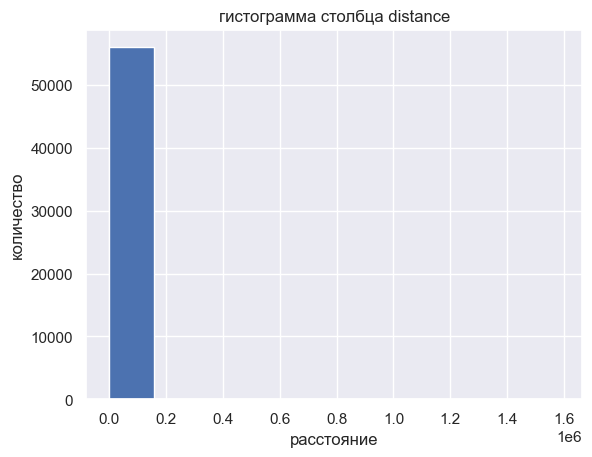

In [26]:
print(df['distance'].describe())
df['distance'].hist()
plt.title('гистограмма столбца distance')
plt.xlabel('расстояние')
plt.ylabel('количество')
plt.show()

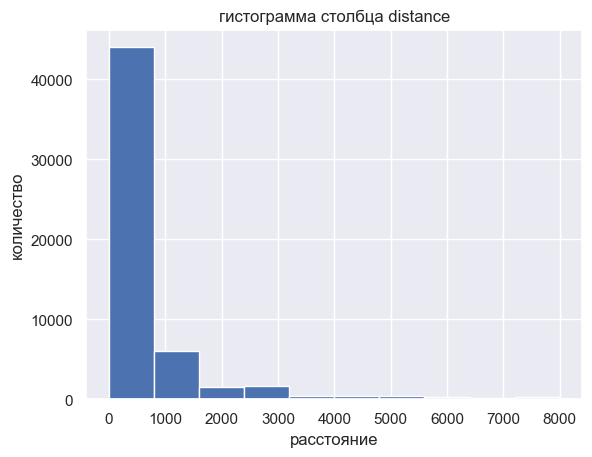

In [27]:
df['distance'].hist(range=(0,8000))
plt.title('гистограмма столбца distance')
plt.xlabel('расстояние')
plt.ylabel('количество')
plt.show()

In [28]:
(df.shape[0] - df[df['distance'] <= 8000].shape[0]) / df.shape[0] * 100

1.6401049381614403

Аномалии состовляют ~1.6% дасета.

In [29]:
df = df[df['distance'] <= 8000]

Аномальные значения были удалены.

#### intersection

In [30]:
df['intersection'].value_counts()

0.0    42576
1.0    12365
Name: intersection, dtype: int64

In [31]:
df['intersection'] = df['intersection'].fillna(0.0)

Пропуски заполнены значением 0.0 - отсутствие перекрёстка.

#### weather_1

In [32]:
df['weather_1'].value_counts(dropna=False)

clear      44191
cloudy      8251
raining     2145
fog          174
None         168
snowing      143
other         31
wind          11
Name: weather_1, dtype: int64

In [33]:
df['weather_1'] = df['weather_1'].fillna('clear')

Пропуски, скорее всего, говорят о том, что погода не повлияла на ДТП.

#### location_type

In [34]:
df['location_type'].value_counts(dropna=False)

None            29948
highway         20565
ramp             3260
intersection     1341
Name: location_type, dtype: int64

In [35]:
(df['location_type'].isna().sum()) / df.shape[0] * 100

54.3382806546431

In [36]:
df[(df['location_type'] == 'intersection') & (df['intersection'] == 0.0)][['intersection', 'location_type']]

,intersection,location_type
107,0.0,intersection
155,0.0,intersection
410,0.0,intersection
551,0.0,intersection
1385,0.0,intersection
...,...,...
55566,0.0,intersection
55706,0.0,intersection
55833,0.0,intersection
56116,0.0,intersection


In [37]:
df = df.drop('location_type', axis=1)

54% значений столбца `location_type` являются пропусками. Кроме того, столбец дублирует информацию из `intersection`, иногда с противоречиями. Было принято решение его удалить.

#### collision_damage

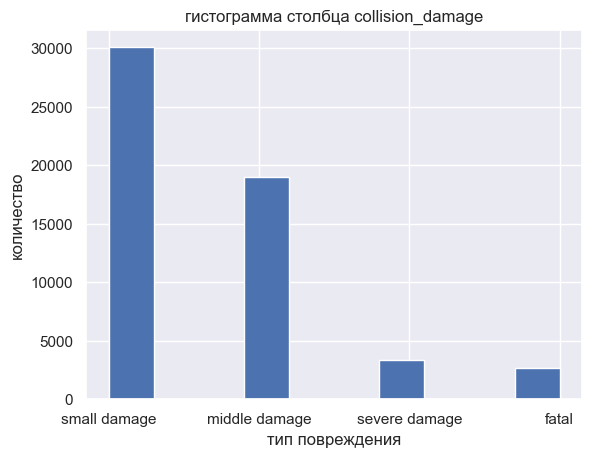

In [38]:
df['collision_damage'].hist()
plt.title('гистограмма столбца collision_damage')
plt.xlabel('тип повреждения')
plt.ylabel('количество')
plt.show()

#### party_count

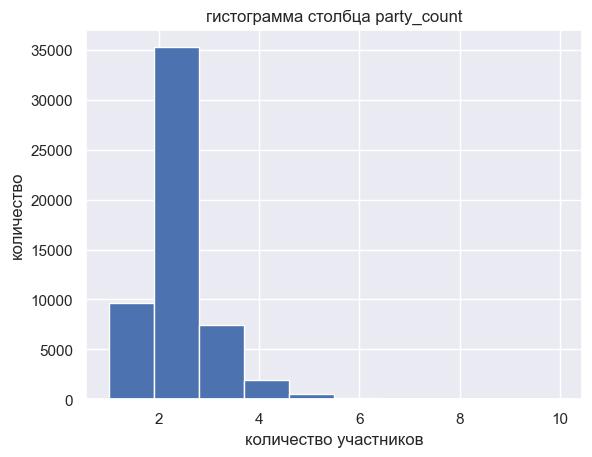

In [39]:
df['party_count'].hist()
plt.title('гистограмма столбца party_count')
plt.xlabel('количество участников')
plt.ylabel('количество')
plt.show()

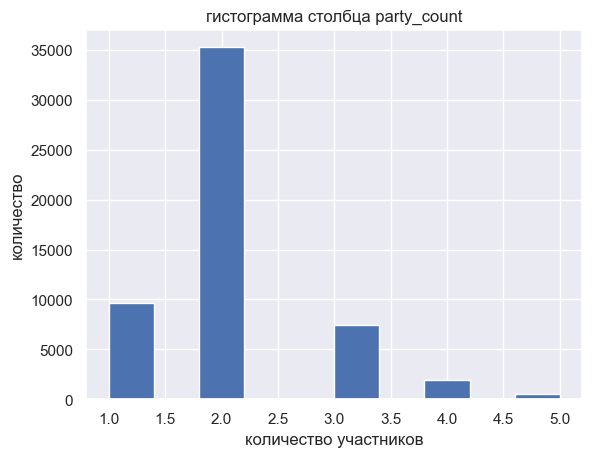

In [40]:
df['party_count'].hist(range=(1, 5))
plt.title('гистограмма столбца party_count')
plt.xlabel('количество участников')
plt.ylabel('количество')
plt.show()

In [41]:
(df.shape[0] - df[df['party_count'] < 6].shape[0]) / df.shape[0] * 100

0.3919149399426643

Аномалии состовляют ~0.4% дасета.

In [42]:
df = df[df['party_count'] < 6]

Аномалии были удалены.

#### primary_collision_factor

In [43]:
df['primary_collision_factor'].value_counts(dropna=False)

vehicle code violation    52645
other than driver          1090
unknown                     829
other improper driving      223
None                        108
fell asleep                   3
Name: primary_collision_factor, dtype: int64

In [44]:
(df.shape[0] - df[df['primary_collision_factor'] != 'vehicle code violation'].shape[0]) / df.shape[0] * 100

95.89602535611498

In [45]:
df = df.drop('primary_collision_factor', axis=1)

Значение `vehicle code violation` состовляет 95% значений столбца. Всязи с этим он не несёт полезной информации и был удалён.

#### pcf_violation_category

In [46]:
df['pcf_violation_category'].value_counts(dropna=False)

speeding                             17766
improper turning                      7818
automobile right of way               7094
dui                                   6086
unsafe lane change                    4598
traffic signals and signs             3355
unsafe starting or backing            1370
wrong side of road                    1300
other than driver (or pedestrian)     1090
following too closely                 1000
unknown                                887
None                                   759
other hazardous violation              504
improper passing                       467
pedestrian violation                   304
other improper driving                 223
pedestrian right of way                112
other equipment                         84
impeding traffic                        33
hazardous parking                       32
brakes                                  10
fell asleep                              3
lights                                   3
Name: pcf_v

In [47]:
df['pcf_violation_category'] = df['pcf_violation_category'].fillna('unknown')
df['pcf_violation_category'] = df['pcf_violation_category'].str.replace('brakes', 'other hazardous violation')
df['pcf_violation_category'] = df['pcf_violation_category'].str.replace('lights', 'other hazardous violation')
df['pcf_violation_category'] = df['pcf_violation_category'].str.replace('fell asleep', 'other hazardous violation')

Редко встречающиеся значения были объеденены с другими, пропуски были заполнены значением `unknown`

#### type_of_collision

In [48]:
df['type_of_collision'].value_counts(dropna=False)

rear end      18389
broadside     11841
sideswipe      9096
hit object     8306
head-on        3194
overturned     2090
other          1679
None            303
Name: type_of_collision, dtype: int64

In [49]:
(df['type_of_collision'].isna().sum()) / df.shape[0] * 100

0.5519326751429925

Пропуски состовляют ~0.5% от датасета.

In [50]:
df = df.dropna(subset=['type_of_collision'], axis=0)

Пропуски были удалены.

#### motor_vehicle_involved_with

In [51]:
df['motor_vehicle_involved_with'].value_counts(dropna=False)

other motor vehicle               40320
fixed object                       7940
non-collision                      2046
other object                       1635
parked motor vehicle               1500
bicycle                             411
motor vehicle on other roadway      405
animal                              212
None                                110
train                                16
Name: motor_vehicle_involved_with, dtype: int64

In [52]:
(df['motor_vehicle_involved_with'].isna().sum()) / df.shape[0] * 100

0.20148365234911622

Пропуски состовляют ~0.2% от датасета.

In [53]:
df = df.dropna(subset=['type_of_collision'], axis=0)
df['motor_vehicle_involved_with'] = df['motor_vehicle_involved_with'].str.replace('train', 'other object')
df['motor_vehicle_involved_with'] = df['motor_vehicle_involved_with'].str.replace('animal', 'other object')
df['motor_vehicle_involved_with'] = df['motor_vehicle_involved_with'].str.replace('motor vehicle on other roadway', 'other motor vehicle')

Пропуски были удалены, редкие и схожие значения были объеденены с другими.

#### road_surface

In [54]:
df['road_surface'].value_counts(dropna=False)

dry         48831
wet          5089
snowy         321
None          314
slippery       40
Name: road_surface, dtype: int64

In [55]:
(df['road_surface'].isna().sum()) / df.shape[0] * 100

0.5751442439783863

Пропуски состовляют ~0.6% от датасета.


In [56]:
df = df.dropna(subset=['road_surface'], axis=0)

Пропуски были удалены.

#### road_condition_1

In [57]:
df['road_condition_1'].value_counts(dropna=False)

normal            52367
construction        960
obstruction         235
other               211
None                171
holes               126
loose material      114
reduced width        66
flooded              31
Name: road_condition_1, dtype: int64

In [58]:
(df.shape[0] - df[df['road_condition_1'] != 'normal'].shape[0]) / df.shape[0] * 100

96.47390431274296

In [59]:
df = df.drop('road_condition_1', axis=1)

Значение `normal` состовляет 96.5% значений столбца. Всязи с этим он почти не несёт полезной информации и был удалён.

#### lighting

In [60]:
df['lighting'].value_counts(dropna=False)

daylight                                   36746
dark with street lights                    10807
dark with no street lights                  4790
dusk or dawn                                1714
dark with street lights not functioning      130
None                                          94
Name: lighting, dtype: int64

In [61]:
(df['lighting'].isna().sum()) / df.shape[0] * 100

0.17317293343895654

Пропуски состовляют ~0.2% от датасета.

In [62]:
df = df.dropna(subset=['lighting'], axis=0)

In [63]:
df['lighting'] = df['lighting'].str.replace('dark with street lights not functioning', 'dark with no street lights')

Пропуски были удалены, редкие значения были объеденены с другими.

#### control_device

In [64]:
df['control_device'].value_counts(dropna=False)

none               36101
functioning        17795
None                 152
not functioning      112
obscured              27
Name: control_device, dtype: int64

In [65]:
(df['control_device'].isna().sum()) / df.shape[0] * 100

0.2805100854448484

Пропуски состовляют ~0.3% от датасета.

In [66]:
df = df.dropna(subset=['control_device'], axis=0)

In [67]:
df['control_device'] = df['control_device'].str.replace('obscured', 'not functioning')

Пропуски были удалены, редкие значения были объеденены с другими.

#### collision_time

In [68]:
df['collision_time'].dtype

dtype('O')

In [69]:
df['collision_time'] = pd.to_datetime(df['collision_time'],format= '%H:%M:%S' ).dt.hour

In [70]:
(df['collision_time'].isna().sum()) / df.shape[0] * 100

0.1462015360414546

Пропуски состовляют ~0.1% от датасета.

In [71]:
df = df.dropna(subset=['collision_time'], axis=0)

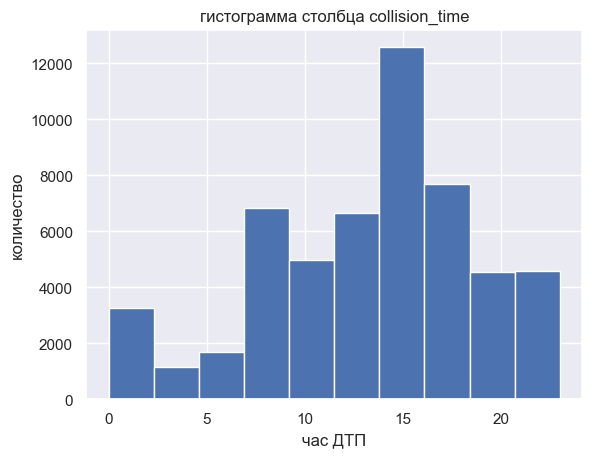

In [72]:
df['collision_time'].hist()
plt.title('гистограмма столбца collision_time')
plt.xlabel('час ДТП')
plt.ylabel('количество')
plt.show()

Данные в столбце `collision_time` были приведены к типу timestamp, затем из них был извлечен час ДТП. Пропуски были удалены.

#### at_fault

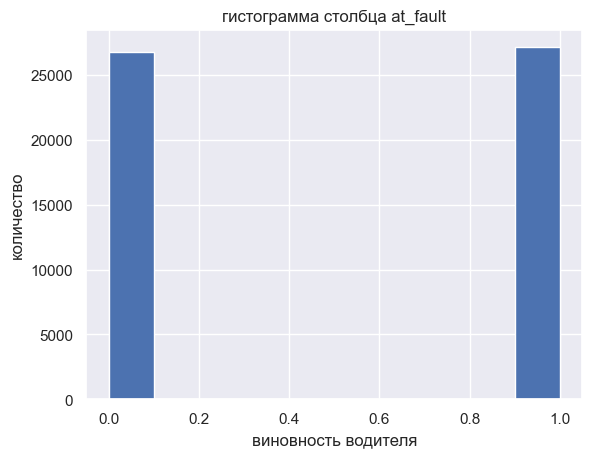

In [73]:
df['at_fault'].hist()
plt.title('гистограмма столбца at_fault')
plt.xlabel('виновность водителя')
plt.ylabel('количество')
plt.show()

Дисбаланс в целевом столбце не наблюдается.

#### party_sobriety

In [74]:
df['party_sobriety'].value_counts(dropna=False)

had not been drinking                     46677
had been drinking, under influence         4273
impairment unknown                         1175
None                                        794
had been drinking, not under influence      548
had been drinking, impairment unknown       247
not applicable                              242
Name: party_sobriety, dtype: int64

In [75]:
df['party_sobriety'] = df['party_sobriety'].fillna('had not been drinking')
df['party_sobriety'] = df['party_sobriety'].str.replace('not applicable', 'had not been drinking')
df['party_sobriety'] = df['party_sobriety'].str.replace('had been drinking, not under influence', 'had not been drinking')
df['party_sobriety'] = df['party_sobriety'].str.replace('had been drinking, impairment unknown', 'impairment unknown')

Пропуски были заполнены значением `had not been drinking`. редкие и схожие значения были объеденены с другими.

#### party_drug_physical

In [76]:
df['party_drug_physical'].value_counts(dropna=False)

None                     51264
G                         1175
under drug influence       798
sleepy/fatigued            361
not applicable             242
impairment - physical      116
Name: party_drug_physical, dtype: int64

In [77]:
(df['party_drug_physical'].isna().sum()) / df.shape[0] * 100

95.01074949959227

Пропуски состовляют ~95% от датасета.

In [78]:
df['party_drug_physical'] = df['party_drug_physical'].apply(lambda x: True if x in ['under drug influence', 'sleepy/fatigued', 'impairment - physical'] else False)

Столбец `party_drug_physical` был переведён в булев тип.

#### cellphone_in_use

In [79]:
df['cellphone_in_use'].value_counts(dropna=False)

0.0    48679
NaN     4258
1.0     1019
Name: cellphone_in_use, dtype: int64

In [80]:
df['cellphone_in_use'] = df['cellphone_in_use'].fillna(0.0)

Пропуски были заполнены значением 0.

#### vehicle_transmission

In [81]:
df['vehicle_transmission'].value_counts(dropna=False)

manual    28015
auto      25116
None        825
Name: vehicle_transmission, dtype: int64

In [82]:
(df['vehicle_transmission'].isna().sum()) / df.shape[0] * 100

1.5290236488991031

Пропуски состовляют ~1.5% от датасета.

In [83]:
df = df.dropna(subset=['vehicle_transmission'], axis=0)

Пропуски были удалены.

#### vehicle_age

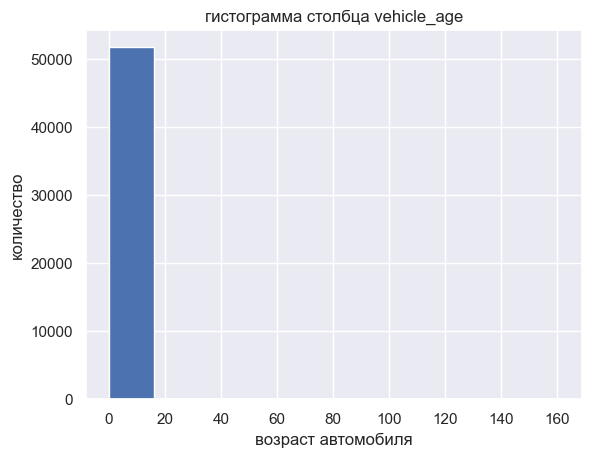

In [84]:
df['vehicle_age'].hist()
plt.title('гистограмма столбца vehicle_age')
plt.xlabel('возраст автомобиля')
plt.ylabel('количество')
plt.show()

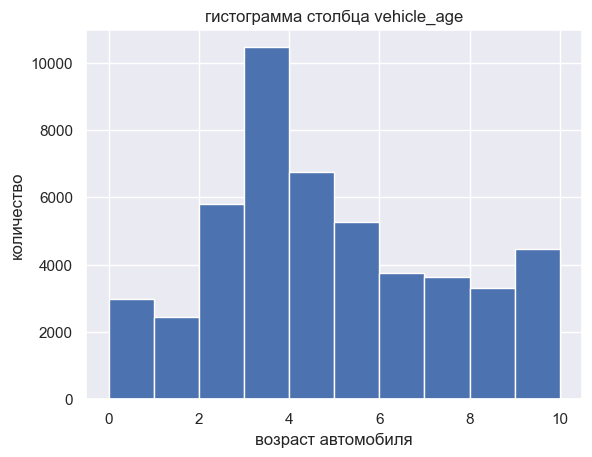

In [85]:
df['vehicle_age'].hist(range=(0, 10))
plt.title('гистограмма столбца vehicle_age')
plt.xlabel('возраст автомобиля')
plt.ylabel('количество')
plt.show()

In [86]:
(df.shape[0] - df[df['vehicle_age'] <= 10].shape[0]) / df.shape[0] * 100 #na included

8.142139240744575

Аномальные значения и пропуски состовляют ~8% от датасета.

In [87]:
df = df[df['vehicle_age'] <= 10]

Аномальные значения и пропуски были удалены.

#### Потеря данных

In [88]:
(initial_len - df.shape[0]) / initial_len * 100

12.89954134170935

В ходе предобработки данных было потеряно 12.9% записей - высокое, но допустимое количество.

### Подготовка данных

In [89]:
X = df.drop('at_fault', axis=1)
y = df['at_fault']

categorical_features = ['intersection', 'weather_1', 'collision_damage', 'pcf_violation_category', 'type_of_collision',
                       'motor_vehicle_involved_with', 'road_surface', 'lighting', 'control_device', 'party_sobriety',
                        'party_drug_physical', 'cellphone_in_use',  'vehicle_transmission']
numerical_features = ['distance', 'party_count', 'collision_time', 'vehicle_age']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1234)

In [90]:
norm = Normalizer()
norm.fit(X_train[numerical_features])
X_train[numerical_features] = norm.transform(X_train[numerical_features])
X_test[numerical_features] = norm.transform(X_test[numerical_features])
X_val[numerical_features] = norm.transform(X_val[numerical_features])

In [91]:
X_train_boost = X_train
X_val_boost = X_val
X_test_boost = X_test

X_train_boost[categorical_features] = X_train_boost[categorical_features].astype('category')
X_val_boost[categorical_features] = X_val_boost[categorical_features].astype('category')
X_test_boost[categorical_features] = X_test_boost[categorical_features].astype('category')

Для xgboost и catboost будут использованы отдельные выборки без кодирования категорий.

In [92]:
transformer = make_column_transformer(
    (OneHotEncoder(drop='first'), categorical_features),
    remainder='passthrough')
transformer.fit(X_train)
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)
X_val = transformer.transform(X_val)

### Обучение моделей

Так как при работе модели будет важна как полнота, так и точность, будет использована метрика, которая их объеденяет - `f1 score`.

In [93]:
predictions_list = []

#### Logistic Regression

In [94]:
parameters = {
    'penalty' : ['none', 'l2'], 
    'C'       : [1.0, 10.0, 100.0],
    'solver'  : ['newton-cg', 'lbfgs', 'sag'],
    'fit_intercept' : [True, False],
    'multi_class' : ['multinomial'],
    'random_state': [123]
}

In [95]:
model = LogisticRegression()
grid = GridSearchCV(model, param_grid=parameters, scoring='f1', error_score='raise')
grid.fit(X_train, y_train);
grid.best_params_

{'C': 1.0,
 'fit_intercept': True,
 'multi_class': 'multinomial',
 'penalty': 'none',
 'random_state': 123,
 'solver': 'sag'}

In [96]:
predictions = grid.predict(X_val)
print('F1 =', f1_score(y_val, predictions))
predictions_list.append(f1_score(y_val, predictions))

F1 = 0.6410321921308124


#### Random Forest

In [97]:
parameters = { 
    'n_estimators': [200, 500, 700],
    'max_depth' : [2, 5, 10, 20],
    'criterion' : ['gini', 'entropy'],
    'random_state' : [123]
}

In [98]:
model = RandomForestClassifier()
grid = GridSearchCV(model, param_grid=parameters, scoring='f1', error_score='raise')
grid.fit(X_train, y_train);
grid.best_params_

{'criterion': 'gini',
 'max_depth': 20,
 'n_estimators': 700,
 'random_state': 123}

In [99]:
predictions = grid.predict(X_val)
print('F1 =', f1_score(y_val, predictions))
predictions_list.append(f1_score(y_val, predictions))

F1 = 0.6344169246646028


#### XGBoost

In [100]:
parameters = {
    'n_estimators' : [200, 500, 700],
    'max_depth' : [2, 5, 10, 20],
    'learning_rate' : [0.1, 0.01, 0.05],
    'random_state' : [123],
    'eval_metric': ['logloss'],
    'enable_categorical': [True],
    'tree_method': ['gpu_hist']
}

In [101]:
model = xgb.XGBClassifier()
grid = GridSearchCV(model, param_grid=parameters, scoring='f1', error_score='raise') 
grid.fit(X_train_boost, y_train);
grid.best_params_

{'enable_categorical': True,
 'eval_metric': 'logloss',
 'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 500,
 'random_state': 123,
 'tree_method': 'gpu_hist'}

In [102]:
predictions = grid.predict(X_val_boost)
print('F1 =', f1_score(y_val, predictions))
predictions_list.append(f1_score(y_val, predictions))

F1 = 0.6669025713611701


#### Catboost

In [103]:
parameters = {'iterations': [100, 300, 500],
          'depth': [4, 5, 6],
          'loss_function': ['Logloss', 'CrossEntropy'],
          'l2_leaf_reg': np.logspace(-20, -19, 3),
          'leaf_estimation_iterations': [10],
          'eval_metric': ['F1'],
          'logging_level':['Silent'],
          'random_seed': [123],
          'cat_features': [categorical_features]
         }

In [104]:
X_train_boost[categorical_features] = X_train_boost[categorical_features].astype('str')
X_val_boost[categorical_features] = X_val_boost[categorical_features].astype('str')

In [105]:
model = CatBoostClassifier()
grid = GridSearchCV(model, param_grid=parameters, scoring='f1', error_score='raise') 
grid.fit(X_train_boost, y_train);
grid.best_params_

{'cat_features': ['intersection',
  'weather_1',
  'collision_damage',
  'pcf_violation_category',
  'type_of_collision',
  'motor_vehicle_involved_with',
  'road_surface',
  'lighting',
  'control_device',
  'party_sobriety',
  'party_drug_physical',
  'cellphone_in_use',
  'vehicle_transmission'],
 'depth': 6,
 'eval_metric': 'F1',
 'iterations': 500,
 'l2_leaf_reg': 1e-20,
 'leaf_estimation_iterations': 10,
 'logging_level': 'Silent',
 'loss_function': 'Logloss',
 'random_seed': 123}

In [106]:
predictions = grid.predict(X_val_boost)
print('F1 =', f1_score(y_val, predictions))
predictions_list.append(f1_score(y_val, predictions))

F1 = 0.6395635796856735


#### Анализ моделей

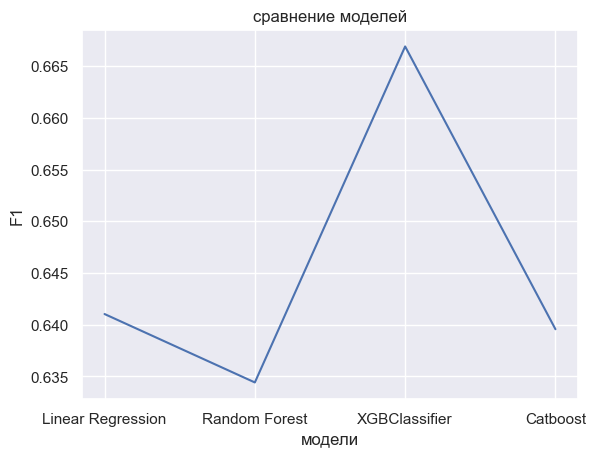

In [107]:
model_list = ['Linear Regression', 'Random Forest', 'XGBClassifier', 'Catboost']
sns.lineplot(x=model_list, y=predictions_list)
plt.title('сравнение моделей')
plt.xlabel('модели')
plt.ylabel('F1')
plt.show()

In [108]:
X_train_boost[categorical_features] = X_train_boost[categorical_features].astype('category')

In [109]:
{'enable_categorical': True,
 'eval_metric': 'logloss',
 'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 700,
 'random_state': 123,
 'tree_method': 'gpu_hist'}

model = xgb.XGBClassifier(eval_metric='logloss', learning_rate=0.1, max_depth=5,
                          n_estimators=700, random_state=123, enable_categorical=True, tree_method='gpu_hist')
model.fit(X_train_boost, y_train)
predictions = model.predict(X_test_boost)
print('F1 =', f1_score(y_test, predictions))

F1 = 0.6619390581717451


После обучения четырех моделей, наилучшей из них оказалась модель XGBclassifier со значением f1 на тестовой выборке 0.66.

## Проведите анализ важности факторов ДТП

### Матрица ошибок

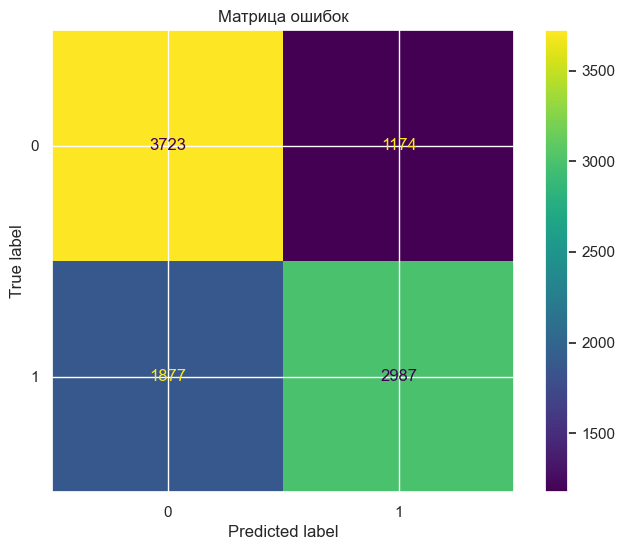

In [110]:
conf_matrix = confusion_matrix(y_test, predictions)
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
display = ConfusionMatrixDisplay(conf_matrix)
ax.set(title='Матрица ошибок')
display.plot(ax=ax);

In [111]:
print('Полнота:', recall_score(y_test, predictions))
print('Точность:', precision_score(y_test, predictions))

Полнота: 0.6141036184210527
Точность: 0.7178562845469839


Модель имеет среднюю полноту и относительно высокую точность.

### Анализ важности факторов

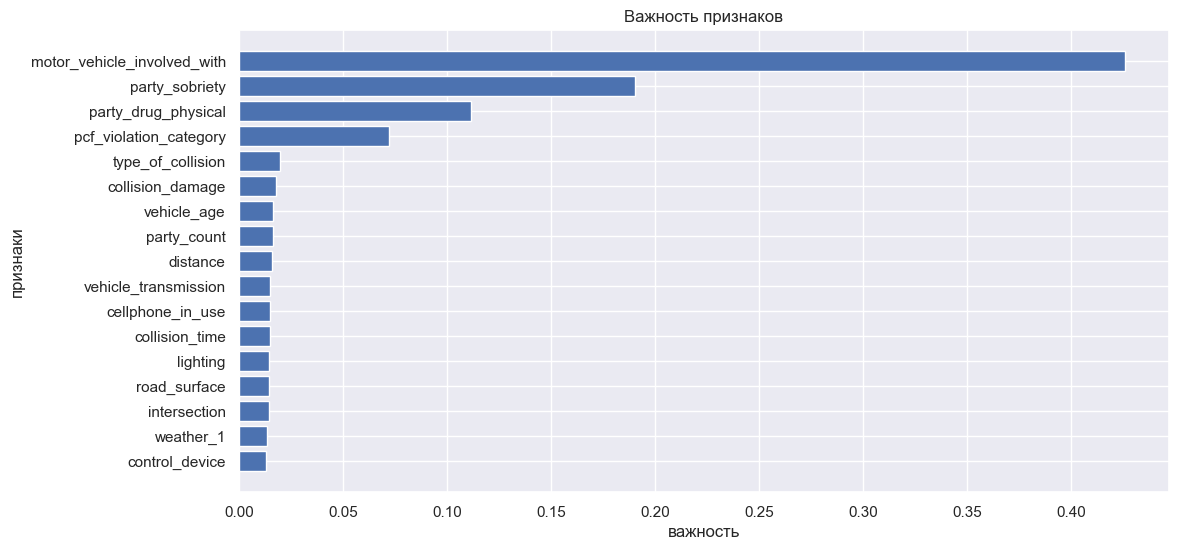

In [112]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(model.feature_names_in_)[sorted_idx])
plt.title('Важность признаков')
plt.xlabel('важность')
plt.ylabel('признаки')
plt.show()

Наиболее важными факторами риска ДТП являются:
* дополнительные участники ДТП;
* трезвость водителя;
* состояние водителя.

### Дополнительное исследование фактора ДТП

In [113]:
df_group = df[['motor_vehicle_involved_with', 'at_fault']].groupby('motor_vehicle_involved_with').mean().sort_values('at_fault', ascending=False)

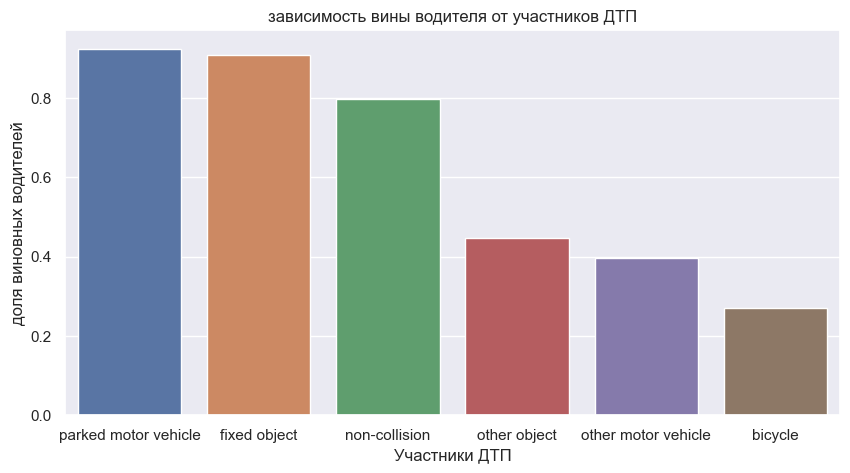

In [114]:
plt.figure(figsize=(10,5))
sns.barplot(x=df_group.index, y=df_group['at_fault'])
plt.title('зависимость вины водителя от участников ДТП')
plt.xlabel('Участники ДТП')
plt.ylabel('доля виновных водителей')
plt.show()

Наболее частые участники ДТП с виной водителя:
* припаркованный автомобиль;
* неподвижный объект;
* не столкновение.

Можно сделать вывод, что большинство ДТП с виной водителя происходит при парковке. Для уменьшения риска предлагается  оборудовать автомобили звуковым сигналом близкости или задней камерой для более безопасной парковки.

## Выводы

Разработанная модель на основе XGBoost имеет достаточно высокую точность и среднюю полноту. В связи с этим, её использование несет низкое количество ложноположительных результатов. Исползование данной модели оправдано, если необходима уверенность в виновности водителя. 

Одним из основных и легко оценивающихся факторов ДТП является трезвость водителя. Если создать возможность его учёта, возможен адекватный рассчёт риска ДТП. Также, стоит обратить внимание на добавление инструментов увеличения безопасности парковки.

Для улучшения работы моделей рекомендуется собрать дополнительные данные о поездке:
* её длительнось;
* планируемое и проеханное расстояние. 